In [99]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit

In [2]:
def peak_marking(y, lag, threshold, influence):
    signals = np.zeros(len(y), dtype=bool)
    filteredY = np.array(y[:lag])
    avgFilter = np.mean(filteredY)
    stdFilter = np.std(filteredY)
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter) > threshold * stdFilter:
            signals[i] = True
            filteredY[i%lag] = influence * y[i] + (1 - influence) * filteredY[(i-1)%lag]
        else:
            signals[i] = False
            filteredY[i%lag] = y[i]
        avgFilter = np.mean(filteredY)
        stdFilter = np.std(filteredY)
    return signals

In [3]:
y = np.array([1,1,1.1,1,0.9,1,1,1.1,1,0.9,1,1.1,1,1,0.9,1,1,1.1,1,1,1,1,1.1,0.9,1,1.1,1,1,0.9,
       1,1.1,1,1,1.1,1,0.8,0.9,1,1.2,0.9,1,1,1.1,1.2,1,1.5,1,3,2,5,3,2,1,1,1,0.9,1,1,3,
       2.6,4,3,3.2,2,1,1,0.8,4,4,2,2.5,1,1,1])

In [4]:
signals = peak_marking(y, 10, 5, 0)


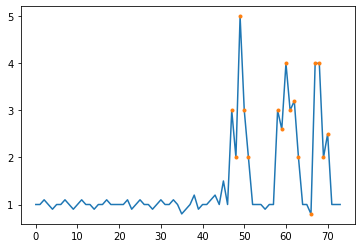

In [7]:
t = np.arange(len(y))
plt.figure()
plt.plot(t,y)
plt.plot(t[signals], y[signals],'.')

In [8]:
signals = signals.astype(bool)

In [13]:
filename = 'mic_data/Fulldata_initiator_19delay.dat'
#filename = '/Users/nams/Downloads/Fulldata_initiator_9delay.dat'


In [14]:
data = np.loadtxt(filename, delimiter=',').flatten()

In [15]:
data.shape

(39744,)

In [17]:
%matplotlib notebook


In [91]:
def sg(x, k=25*4):
    Pxx = []
    N = 64*4
    # k = 26*4
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    # Initialize... no sliding because there aren't enough samples
    z1=0;
    z2=0;
    for idx in range(N):
        z0 = x[idx] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

    # I = cw*z1 -z2;
    # Q = sw*z1;

    P = z2*z2 + z1*z1 - c * z1*z2
    print('P',P)
    Pxx.append(P)
    # return I, Q, P

    while (idx < (len(x)-1)):
        idx += 1
        z0 = x[idx] - x[idx-N] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        P = z2*z2 + z1*z1 - c * z1*z2
        Pxx.append(P)

    return np.array(Pxx)

In [ ]:
filtered = sg(d)

In [18]:
# Sliding Goertzel
@jit
def sg_v2(x, k=25*4):
    Pxx = []
    N = 64*4
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    z1=0;
    z2=0;
    #while (idx < (len(x)-1)):
    for idx in range(len(x)):
        if idx<N:
            z0 = x[idx] + c*z1 - z2;
        else:
            z0 = x[idx] - x[idx-N] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        P = z2*z2 + z1*z1 - c * z1*z2
        Pxx.append(P)
    return np.array(Pxx)

In [20]:
filtered = sg_v2(data)

In [23]:
len(filtered)/64

621.0

<IPython.core.display.Javascript object>


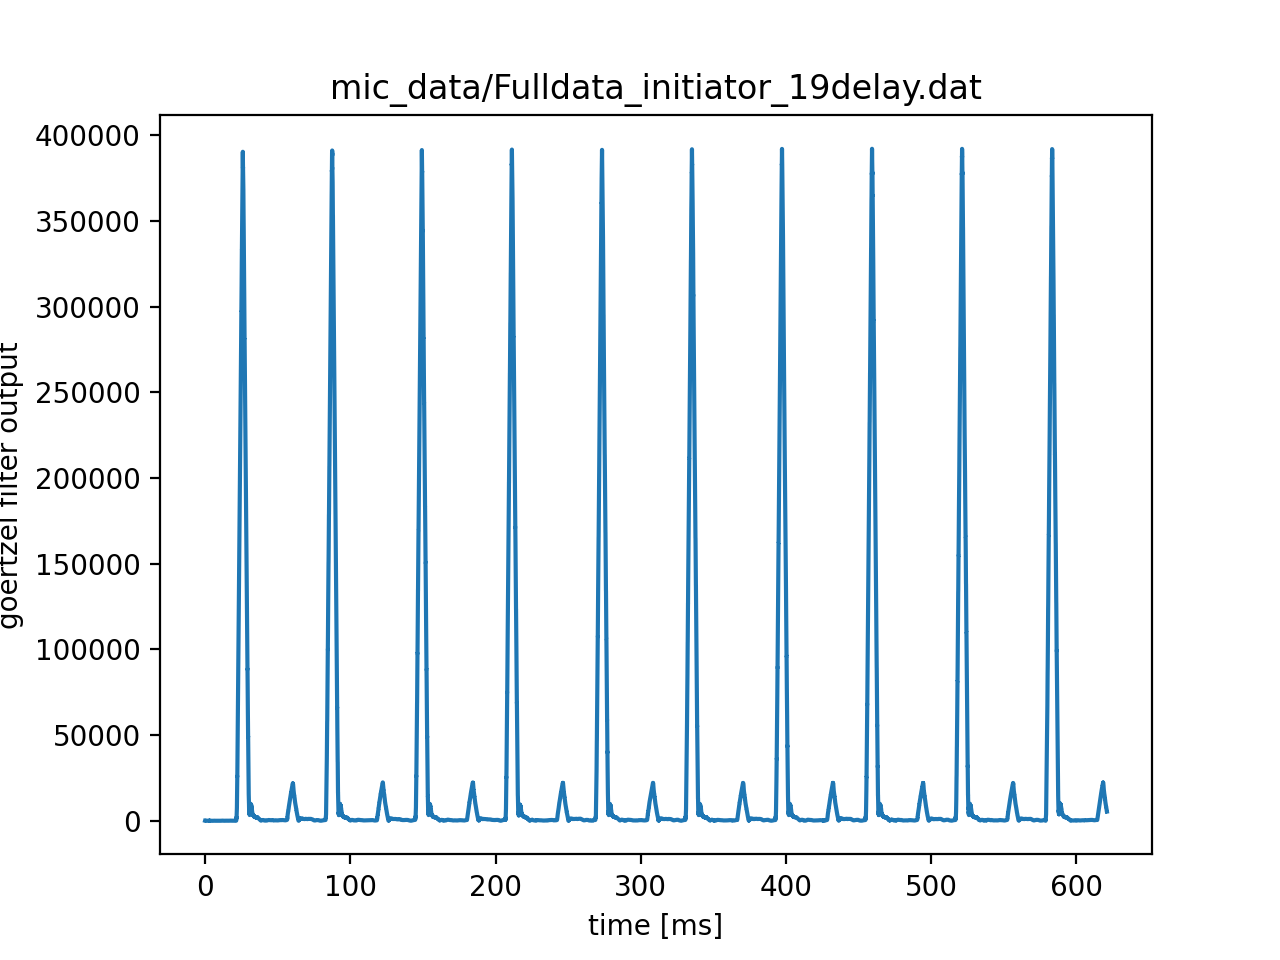

Text(0, 0.5, 'goertzel filter output')

In [21]:
plt.figure()
plt.plot(np.arange(len(filtered))/64, filtered**0.5)
plt.title(filename)
plt.xlabel('time [ms]')
plt.ylabel('goertzel filter output')

In [24]:
y = (2*filtered)**0.5;
signals = thresholding_algo_v3(y, 256, 5, 0.00001)
signals = signals.astype(bool)
t = np.arange(len(y))
plt.figure()
plt.plot(t,y)
plt.plot(t[signals], y[signals],'.')

NameError: name 'thresholding_algo_v3' is not defined

In [128]:
signals

array([False, False, False, ..., False, False, False])

In [129]:
signals.sum()

21075

<IPython.core.display.Javascript object>


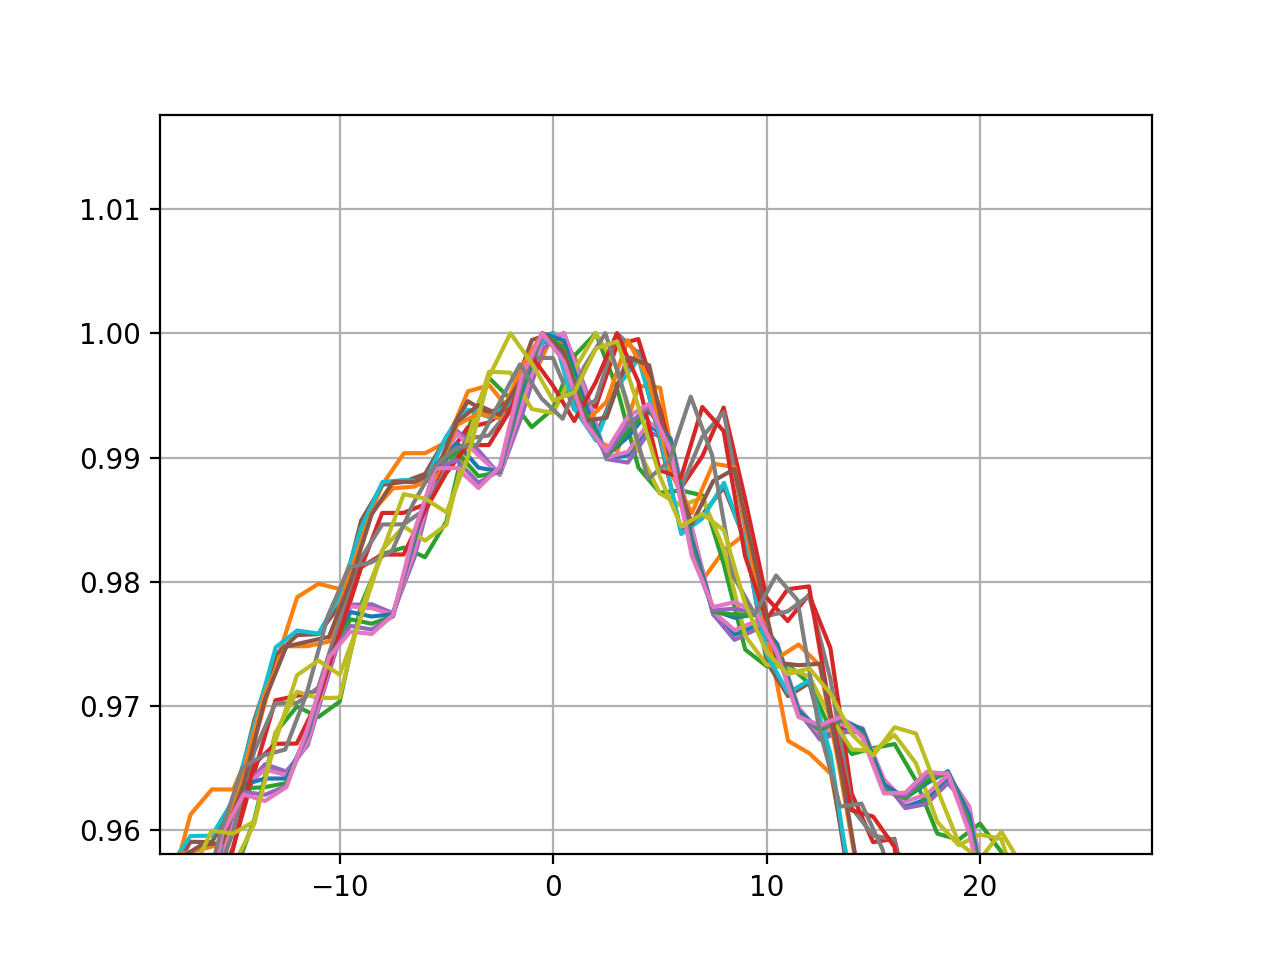

In [286]:
signals = thresholding_algo_v3(y, 256, 5, 1e-4)
signals = signals.astype(bool)

found_one = False
start = []
lengths = []
for idx in range(len(signals)):
    if not found_one and signals[idx]:
        found_one = True
        start.append(idx)
        length = 1
    elif found_one and not signals[idx]:
        lengths.append(length)
        found_one = False
    elif found_one and signals[idx]:
        length += 1
plt.figure()
for idx in range(len(start)-1):
    if lengths[idx] > 100:
        idx = range(start[idx], start[idx] + lengths[idx])
        normalized = y[idx]/max(y[idx])
        good = normalized > 0.98
        avg = (y[idx][good]*np.array(idx)[good]).sum() / y[idx][good].sum()
        #avg = (y[idx]*np.array(idx)).sum() / y[idx].sum()
        plt.plot(np.array(idx) - avg, y[idx]/max(y[idx]))
        #print(avg)
plt.grid(True)        

In [228]:
for idx in range(2):
    if lengths[idx] > 100:
        idx = range(start[idx], start[idx] + lengths[idx])
        normalized = y[idx]/max(y[idx])
        good = normalized > 0.98
        avg = (y[idx][good]*np.array(idx)[good]).sum() / y[idx][good].sum()
        #avg = (y[idx]*np.array(idx)).sum() / y[idx].sum()
        plt.plot(np.array(idx) - avg, y[idx]/max(y[idx]))
        #print(avg)
plt.grid(True)        

In [70]:
def pk_find(y, lag, threshold, influence):
    found_one = False
    starts = []
    lengths = []
    signals = np.zeros(len(y))
    filteredY = np.array(y[:lag])
    avgFilter = np.mean(filteredY)
    avg = avgFilter
    stdFilter = np.std(filteredY)
    std2 = stdFilter**2;
    for i in range(lag, len(y)):
        oldValue = filteredY[i%lag]
        if (y[i] - avgFilter) > threshold * stdFilter:
            signals[i] = 1
            if not found_one:
                length = 1
                starts.append(i)
                found_one = True
            else:
                length += 1
            filteredY[i%lag] = influence * y[i] + (1 - influence) * filteredY[(i-1)%lag]
        else:
            if found_one:
                lengths.append(length)
                length = 0
                found_one = False
            signals[i] = 0
            filteredY[i%lag] = y[i]
        #avgFilter = np.mean(filteredY)
        prev_avg = avg
        avg = avg + (filteredY[i%lag] - oldValue) / lag
        avgFilter = avg;
        #print(avgFilter-avg)
        #stdFilter = np.std(filteredY)
        std2 = std2 + (filteredY[i%lag] - oldValue)*(filteredY[i%lag] + oldValue - avg - prev_avg) /lag
        stdFilter = std2**0.5
        # print(stdFilter-(std2**0.5), stdFilter, std2**0.5)
    return signals, starts, lengths

In [294]:
signals, s, l = pk_find(y, 256, 5, 1e-4)
signals = signals.astype(bool)


In [692]:
np.array(lengths) - np.array(l), np.array(start) - np.array(s), s  

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([ -1117,  -3363,  -5057,  -7325,  -9010, -11291, -12982, -12987,
        -12991, -15260, -16949, -19229, -20913, -20917, -23205, -24880,
        -27163, -28848, -31132, -32817, -32821, -35099, -36791, -36796,
        -39067, -39070]),
 [1117,
  3363,
  5057,
  7325,
  9010,
  11291,
  12982,
  12987,
  12991,
  15260,
  16949,
  19229,
  20913,
  20917,
  23205,
  24880,
  27163,
  28848,
  31132,
  32817,
  32821,
  35099,
  36791,
  36796,
  39067,
  39070])

In [813]:
lag = 256
threshold = 5
influence = 1e-4
settings = (lag, threshold, influence)
#filteredY = np.array(y[:lag])
#avgFilter = np.mean(filteredY)
#stdFilter = np.std(filteredY)
#std2 = stdFilter**2;
filteredY = np.zeros(lag)
avgFilter = 0
std2 = 0
pk_info = [0, 0, 0]
time = -1
start = 0
write_addr = 0
found_one = False
length = 0

history = (filteredY, avgFilter, std2, pk_info, time, start, found_one, length)
def fill_ring():
    idx = range(write_addr, write_addr + 64)
    ring[idx & 0xFFFFFF] = y[idx]
    write_addr += 64;
    
def pk_find_block(y, settings, history):
    lag, threshold, influence = settings
    filteredY, avgFilter, std2, pk_info, time, start, found_one, length = history

    peaks = []
    write_addr = pk_find_block.write_addr
    for i in range(len(y)):
        stdFilter = std2**0.5;
        time += 1
        oldValue = filteredY[(write_addr + i)%lag]
        if (y[i] - avgFilter) > threshold * stdFilter and (write_addr+i)>=lag:
            #print(i, 1, time)
            if not found_one:
                length = 1
                start = time
                found_one = True
            else:
                length += 1
            if y[i] > pk_info[1]:
                pk_info = [i, y[i], start, time]
            filteredY[(write_addr + i)%lag] = influence * y[i] + (1 - influence) * filteredY[((write_addr + i)-1)%lag]
        else:
            if found_one:
                if length>100:
                    pk_info.append(length)
                    peaks.append(pk_info)
                    # print("Mark Peak", 20*"*")
                    time = start + length - pk_info[3]
                    pk_info = [0, 0, 0]
                start = 0
                length = 0
                found_one = False
            filteredY[(write_addr + i)%lag] = y[i]
        prev_avg = avgFilter
        avgFilter = avgFilter + (filteredY[(write_addr + i)%lag] - oldValue) / lag
        std2 = std2 + (filteredY[(write_addr + i)%lag] - oldValue)*(filteredY[(write_addr + i)%lag] + oldValue - avgFilter - prev_avg) /lag
        #stdFilter = std2**0.5
    write_addr += len(y);
    #write_addr %= lag;
    pk_find_block.write_addr = write_addr
    # in the middle of a peak... record it anyway
#     if found_one:
#         if length>100 and (pk_info[0]+20) < i:
#             pk_info.append(length)
#             peaks.append(pk_info)
    history = (filteredY, avgFilter, std2, pk_info, time, start, found_one, length)
    return peaks, history
pk_find_block.write_addr = 0


<IPython.core.display.Javascript object>


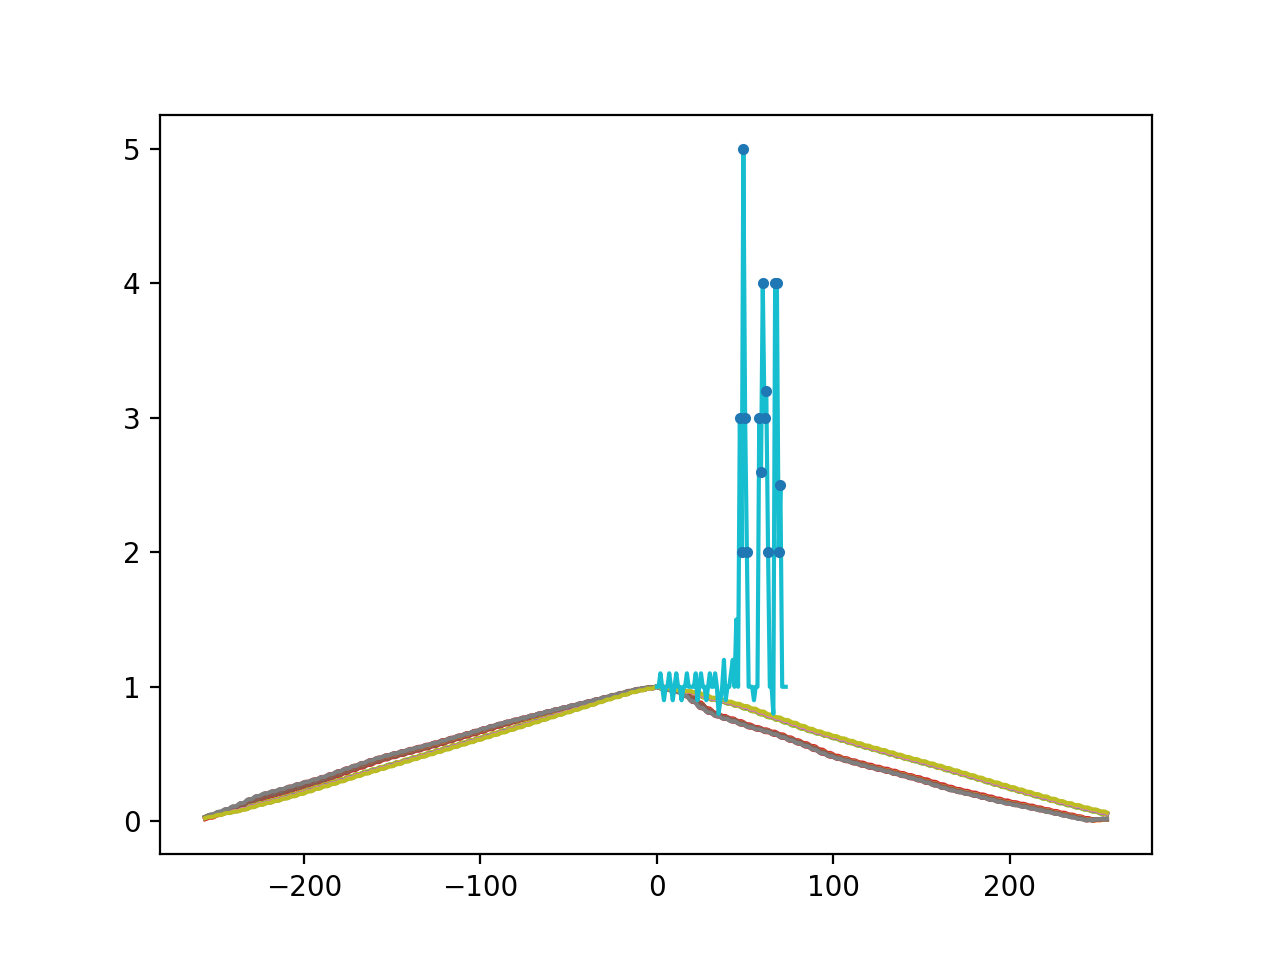

19

In [815]:
lag = 256
threshold = 5
influence = 1e-4
settings = (lag, threshold, influence)
filteredY = np.zeros(lag)
time=-1
start = 0
pk_find_block.write_addr = 0
pk_info = [0, 0, 0]
found_one = False
length = 0
peaks, history= pk_find_block(y, settings, history)
plt.figure()
count = 0
for pkinfo in peaks:
    idx = np.arange(pkinfo[0]-256, min(pkinfo[0]+256, len(y)))
    plt.plot(idx-pkinfo[0], y[idx]/pkinfo[1])
    count += 1
#peaks #, pk_find_block.write_addr, filteredY, avgFilter, std2
len(peaks)

In [816]:
lag = 256
threshold = 5
influence = 1e-4
settings = (lag, threshold, influence)
filteredY = np.zeros(lag)
avgFilter = 0
std2 = 0
pk_info = [0, 0, 0]
time=-1
start = 0
found_one = False
length = 0
pk_find_block.write_addr = 0
history = (filteredY, avgFilter, std2, pk_info, time, start, found_one, length)
# plt.figure()
#for count in range(64):
p = []
for count in range(len(y)>>6):
    if count < 4:
        search = False
    else:
        search = True
    idx = range(count*64, (count+1)*64)
    peaks, history = pk_find_block(y[idx], settings, history)
    #peaks, avgFilter, std2, pk_info, time, start, found_one, length = pk_find_block(y[idx], 
    #                        settings, filteredY, avgFilter, std2, pk_info, time, start, found_one, length)
    # plt.plot(idx,y[idx])
    # print(pk_find_block.write_addr, avgFilter, std2, time, start, pk_info, found_one, length)
    if len(peaks):
        print(peaks[0])
        p.append(peaks[0])
print(len(p))    
res = (filteredY, avgFilter, std2)

[0, 552092.542012236, 1117, 1408, 551]
[29, 30923.176219004126, 1955, 2205, 476]
[34, 553156.2738243787, 1444, 1733, 546]
[23, 31660.17154253565, 1979, 2229, 478]
[18, 553501.6748050731, 1435, 1723, 548]
[25, 31642.966913015913, 1993, 2247, 482]
[18, 553914.6928937301, 1446, 1721, 535]
[26, 31369.125306529422, 1994, 2248, 475]
[22, 553671.7395027501, 1435, 1724, 546]
[27, 31311.267665934414, 1991, 2245, 478]
[17, 554163.3110558526, 1434, 1718, 545]
[31, 31264.173297019628, 2004, 2254, 471]
[17, 554464.135443217, 1425, 1714, 550]
[26, 31299.77006466669, 1994, 2249, 479]
[17, 554554.5953738769, 1430, 1719, 550]
[26, 31227.307683650644, 1995, 2249, 479]
[17, 554500.0358448587, 1435, 1719, 545]
[26, 31222.822854347243, 1994, 2249, 476]
[17, 554297.1069657183, 1442, 1719, 541]
19


In [811]:
len(pks)

19

In [817]:
np.array(p)[:,3].cumsum()-256

array([ 1152.,  3357.,  5090.,  7319.,  9042., 11289., 13010., 15258.,
       16982., 19227., 20945., 23199., 24913., 27162., 28881., 31130.,
       32849., 35098., 36817.])

In [725]:
pks, np.diff(np.array(pks)[:,0])[2::2].std(), np.diff(np.array(pks)[:,1])[2::2].std()

([[1152, 1151.5023874192184],
  [3357, 3356.992981706241],
  [5090, 5088.004040766777],
  [7319, 7319.011800022698],
  [9042, 9041.502494049535],
  [11289, 11288.997237553349],
  [13010, 13009.502685356205],
  [15258, 15255.011504734915],
  [16982, 16980.00314728667],
  [19227, 19226.997617721794],
  [20945, 20945.50244827377],
  [23199, 23199.503081112172],
  [24913, 24913.50239868641],
  [27162, 27159.012487392192],
  [28881, 28881.502394749365],
  [31130, 31130.502718561856],
  [32849, 32849.502466374244],
  [35098, 35095.55532275034],
  [36817, 36819.00140841797]],
 6.94172168845741,
 6.1313573942327855)

In [597]:
def foo():
    foo.counter += 1
    print("Counter is %d" % foo.counter)
foo.counter = 0

In [742]:
foo()

Counter is 1


In [767]:
class peak_finder:
    lag = 256
    threshold = 5
    influence = 1e-4
    filteredY = np.array(y[:lag])
    avgFilter = np.mean(filteredY)
    stdFilter = np.std(filteredY)
    std2 = stdFilter**2;
    pk_info = [0, 0, 0]
    time = -1
    start = 0
    write_addr = 0
    found_one = False
    length = 0


    def pk_find_block(y, lag, threshold, influence, filteredY, avgFilter, std2, pk_info, time, start, found_one, length):
        peaks = []
        write_addr = pk_find_block.write_addr
        for i in range(len(y)):
            stdFilter = std2**0.5;
            time += 1
            oldValue = filteredY[(write_addr + i)%lag]
            if (y[i] - avgFilter) > threshold * stdFilter and (write_addr+i)>=lag:
                #print(i, 1, time)
                if not found_one:
                    length = 1
                    start = time
                    found_one = True
                else:
                    length += 1
                if y[i] > pk_info[1]:
                    pk_info = [i, y[i], start, time]
                filteredY[(write_addr + i)%lag] = influence * y[i] + (1 - influence) * filteredY[((write_addr + i)-1)%lag]
            else:
                if found_one:
                    if length>100:
                        pk_info.append(length)
                        peaks.append(pk_info)
                        # print("Mark Peak", 20*"*")
                        time = start + length - pk_info[3]
                        pk_info = [0, 0, 0]
                    start = 0
                    length = 0
                    found_one = False
                filteredY[(write_addr + i)%lag] = y[i]
            prev_avg = avgFilter
            avgFilter = avgFilter + (filteredY[(write_addr + i)%lag] - oldValue) / lag
            std2 = std2 + (filteredY[(write_addr + i)%lag] - oldValue)*(filteredY[(write_addr + i)%lag] + oldValue - avgFilter - prev_avg) /lag
            #stdFilter = std2**0.5
        write_addr += len(y);
        #write_addr %= lag;
        pk_find_block.write_addr = write_addr
        # in the middle of a peak... record it anyway
    #     if found_one:
    #         if length>100 and (pk_info[0]+20) < i:
    #             pk_info.append(length)
    #             peaks.append(pk_info)
        return peaks, avgFilter, std2, pk_info, time, start, found_one, length
    pk_find_block.write_addr = 0


In [100]:
@njit
def peak_marking_v2(y, lag, threshold, influence, width, signals): #, filteredY):
    print("width", width)
    #signals = np.zeros(len(y), dtype=int)
    #filteredY = np.array(y[:lag])
    filteredY = y[:lag] + 0  # make a copy of the first part of y... compatible with jit
    avgFilter = np.mean(filteredY)
    stdFilter = np.std(filteredY)
    filteredY = np.zeros(lag)
    avgFilter = 0
    stdFilter = 0
    std2 = stdFilter**2
    pks = []
    start, length, pk, pk_idx = -1, 0, -1, -1
    for i in range(0, len(y)):
        if i == lag:
            print(avgFilter, stdFilter)
        oldValue = filteredY[i%lag] # store this for use to update mean and std
        if abs(y[i] - avgFilter) > threshold * stdFilter and (i>=lag):
            if (y[i] > avgFilter):
                signals[i] = 1
                if start<0:
                    start, length = i, 1
                else:
                    length += 1
                if y[i]>pk:
                    pk, pk_idx = y[i], i
#             else:
#                 signals[i] = -1
#                 if (start>0) and (length>width):
#                     pks.append([start, length, pk_idx, pk])
#                     #print(start, length, pk)
#                     start, length, pk, pk_idx = -1, 0, -1, -1
            filteredY[i%lag] = influence * y[i] + (1 - influence) * filteredY[(i-1)%lag]
        else:
            signals[i] = 0
            filteredY[i%lag] = y[i]
            if (start>0) and (length>width):
                #print(length)
                pks.append([start, length, pk_idx, pk])
                # print(start, length, pk, pk_idx)
                start, length, pk, pk_idx = -1, 0, -1, -1
        prevAvg = avgFilter
        avgFilter = avgFilter + (filteredY[i%lag] - oldValue) / lag
        #print(prevAvg, avgFilter, filteredY[i%lag], oldValue)
        # avgFilter = np.mean(filteredY)
        std2 = std2 + (filteredY[i%lag] - oldValue)*(filteredY[i%lag] + oldValue - avgFilter - prevAvg) /lag
        stdFilter = std2**0.5
        #stdFilter = np.std(filteredY)
    return signals, pks

In [101]:
raw = np.fromfile('mic_data/single_tone_v2.dat', dtype=np.int32)
data = raw>>14


In [102]:
y = (2*sg_v2(data, k=100))**0.5


In [117]:
lag = 256
threshold = 5
latency = 1e-3
width = 128
signals = np.zeros(len(y), dtype=int)
filteredY = np.array(y[:lag])
signals, pks = peak_marking_v2(y, lag, threshold, latency, width, signals) #, filteredY)
pks

width 128
12373.131887395368 3585.7096795179577


[[25869.0, 464.0, 26169.0, 35246.76273914424],
 [114251.0, 468.0, 128569.0, 35489.29666356729],
 [165870.0, 475.0, 230969.0, 34712.375558673055],
 [257612.0, 459.0, 333369.0, 35423.24997654635],
 [350826.0, 459.0, 435768.0, 35674.1233978497],
 [444155.0, 460.0, 538170.0, 37568.66152397885],
 [554973.0, 468.0, 640570.0, 35950.980345918324],
 [650467.0, 460.0, 742970.0, 35987.661551299294],
 [775656.0, 466.0, 845351.0, 37026.29432413915],
 [886724.0, 469.0, 947769.0, 37154.85769558828],
 [981060.0, 471.0, 1050169.0, 36987.05679952423],
 [1079862.0, 476.0, 1152569.0, 36731.42815123614],
 [1189665.0, 457.0, 1254969.0, 36927.695199386675]]

<IPython.core.display.Javascript object>


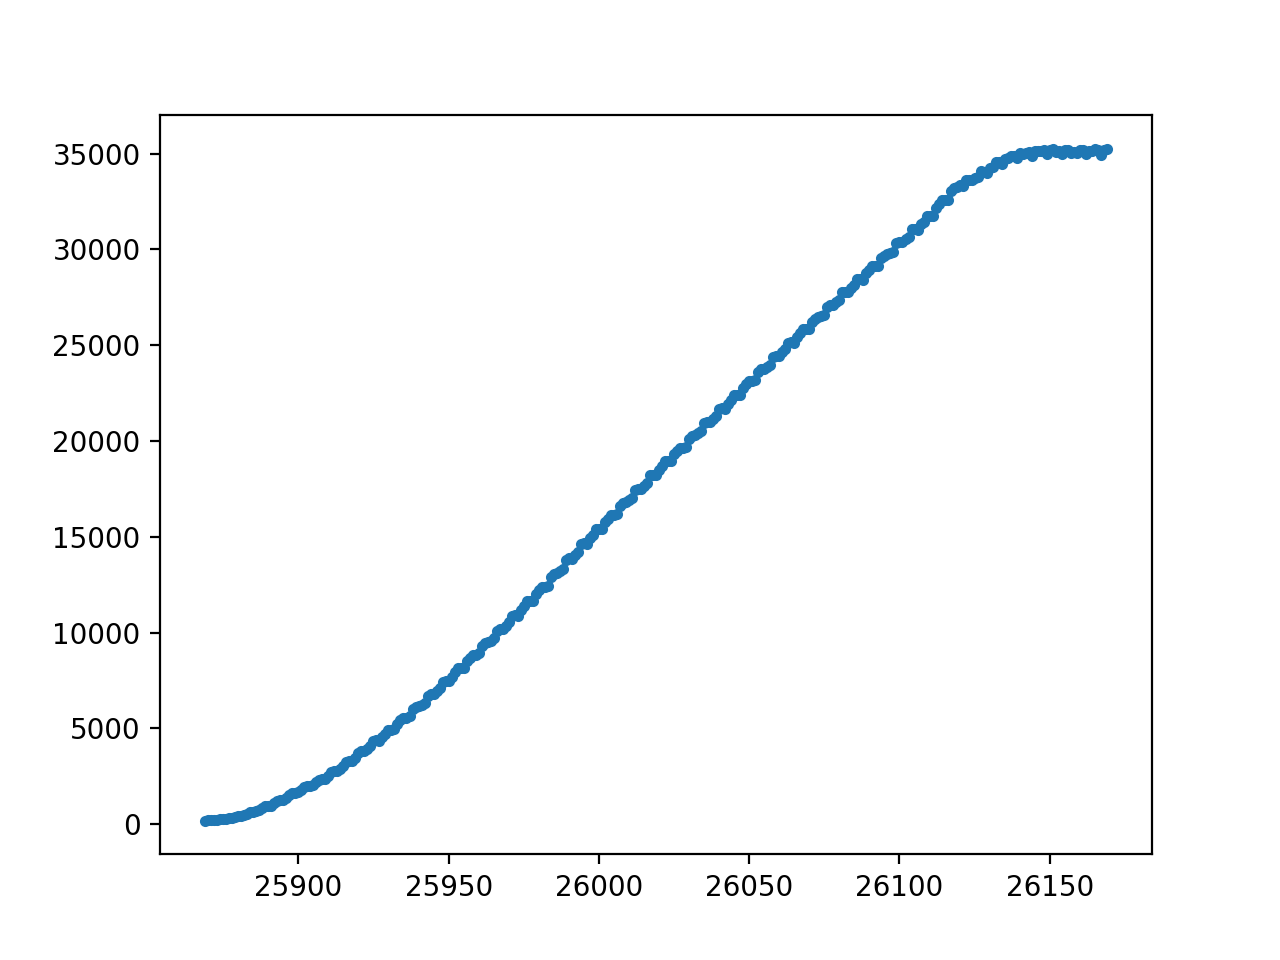

In [115]:
%matplotlib notebook
plt.figure()
start = 25869
stop = 26170
t = np.arange(start, stop)

plt.plot(t, y[t], '.')

<IPython.core.display.Javascript object>


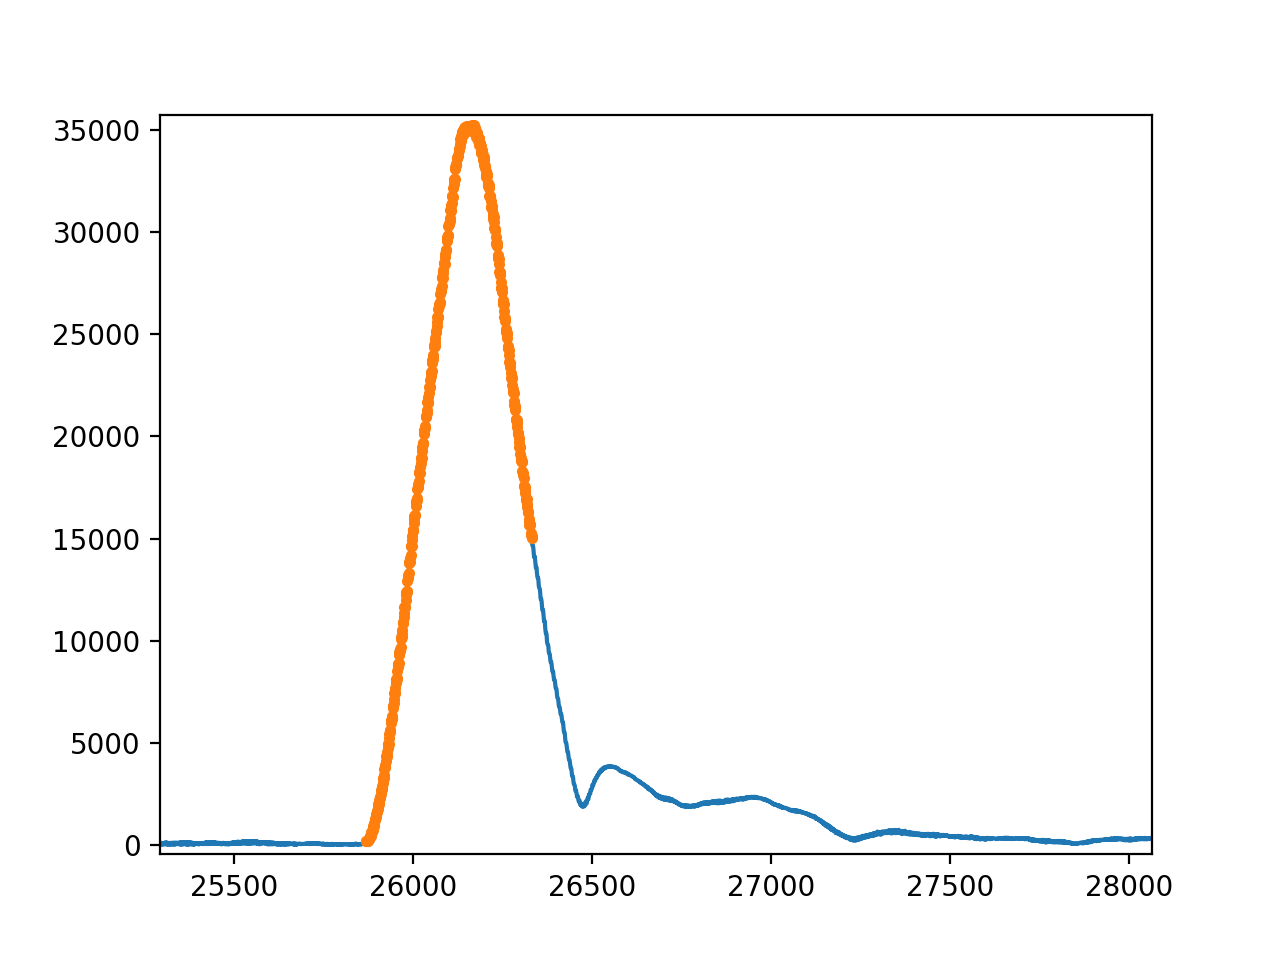

In [119]:
%matplotlib notebook
plt.figure()
t = np.arange(len(y))
plt.plot(y)
plt.plot(t[signals==1], y[signals==1], '.')

In [111]:
marks, s, l = pk_find(y, 256, 5, 1e-4)
marks = marks.astype(bool)

In [112]:
l = np.array(l)
s = np.array(s)
l[l>10]
s[l>10]


array([  25869,  128274,  128895,  230677,  333078,  333695,  435482,
        436094,  537876,  538492,  640275,  742679,  845074,  947474,
        948096, 1049874, 1152274, 1254678, 1255291])

<IPython.core.display.Javascript object>


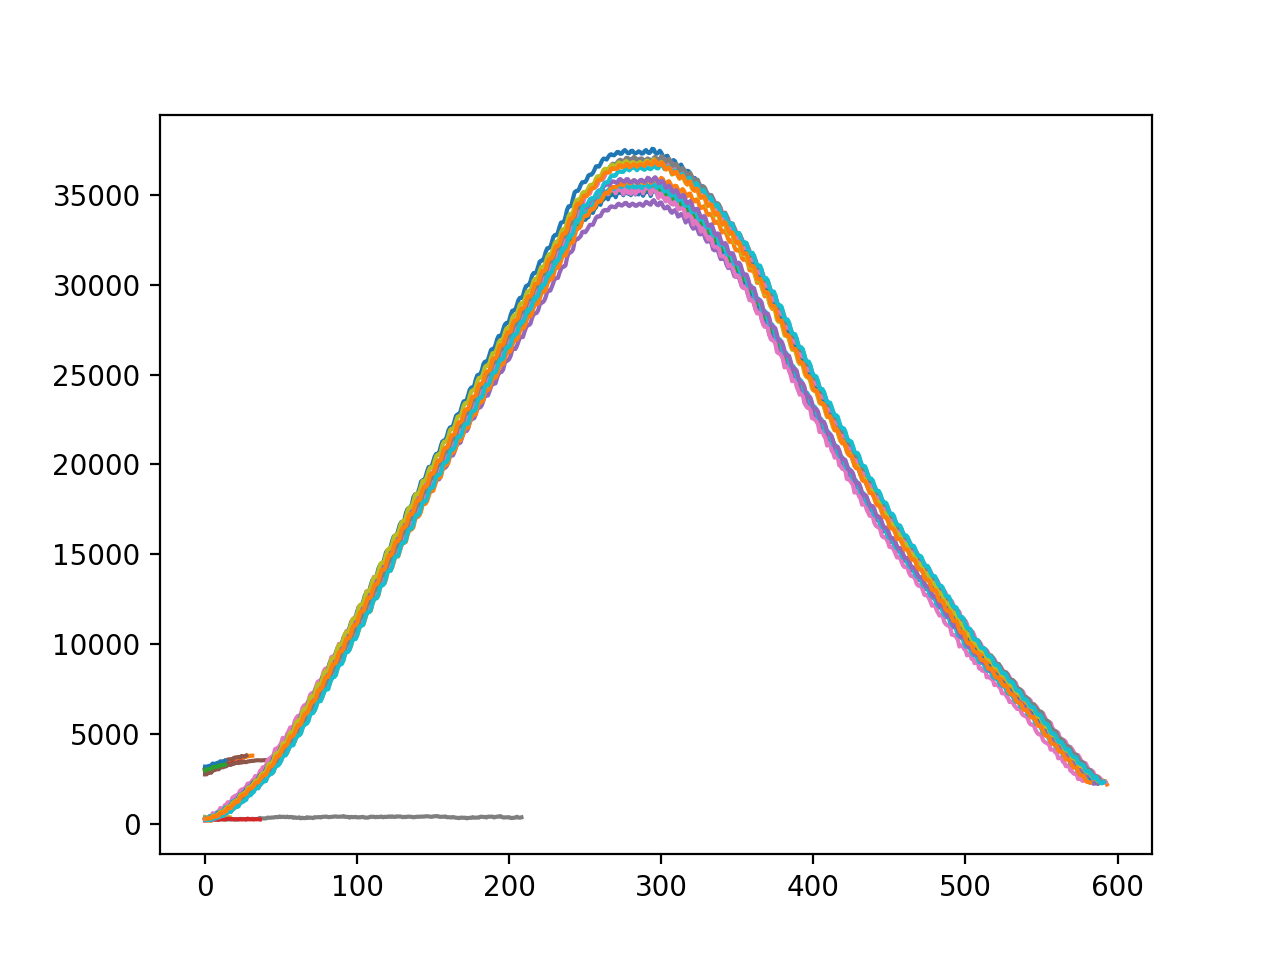

In [96]:
plt.figure();
s = s[l>10];
l = l[l>10];
for i in range(len(l)):
    plt.plot(y[s[i]:(s[i]+l[i])])

<IPython.core.display.Javascript object>


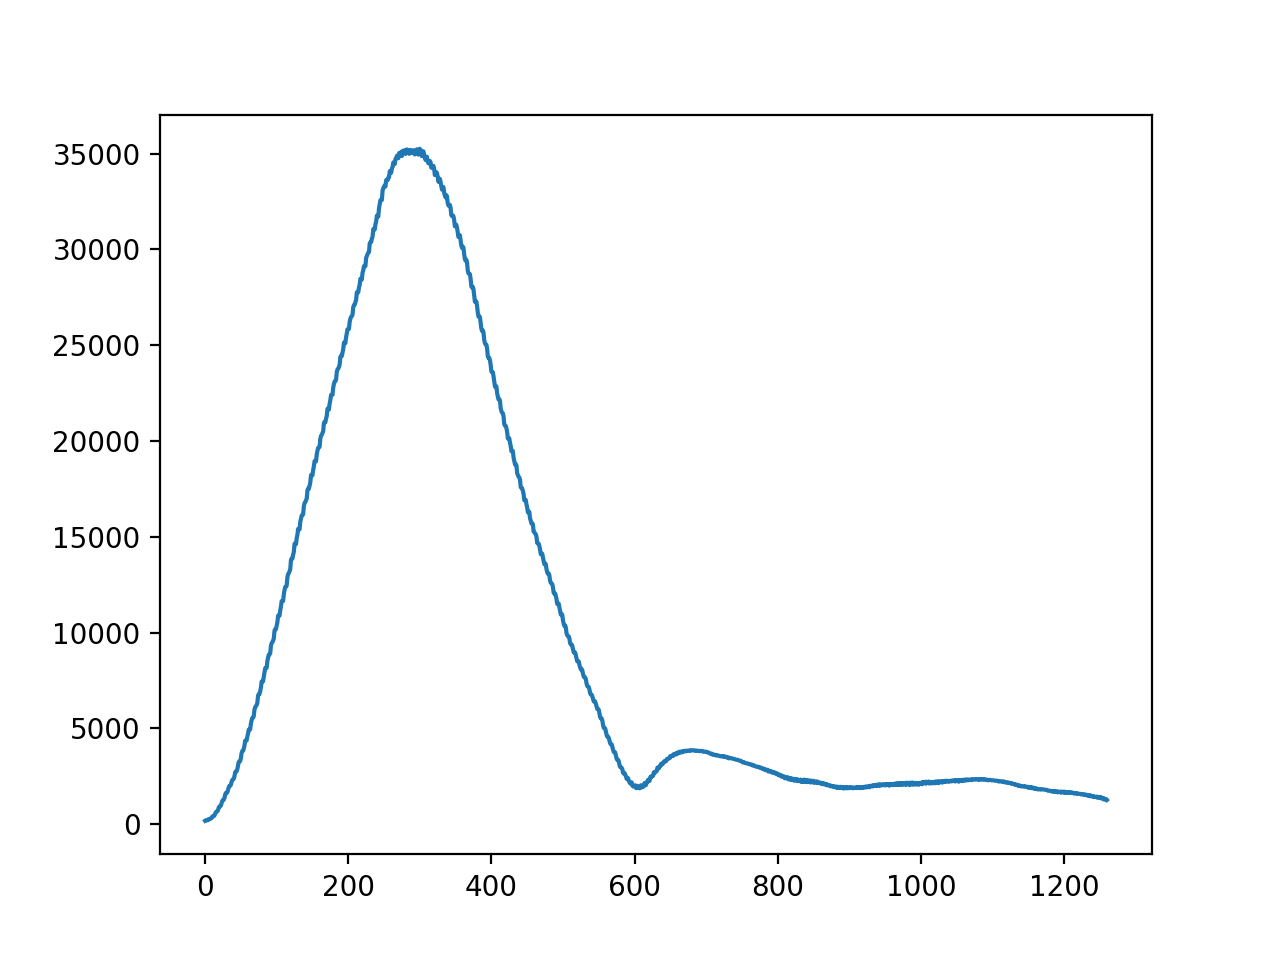

In [67]:
plt.figure()
plt.plot(y[25869:27130])